Granullar PPO Priority Analysis

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import subprocess
import os

from utils import init_nodes
from spam_cluster import get_response_times
from pod_controller import get_loadbalancer_external_port, set_container_cpu_values

# Set the working directory to the root of the project
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
os.chdir(parent_dir)

print(f'Current working directory: {os.getcwd()}')

divide_at = 3

interval = 1000
rps = 100
random_rps = False
# every = 3
initial_rps = rps

upper_rps = 60
lower_rps = 30

url = f"http://localhost:{get_loadbalancer_external_port(service_name='ingress-nginx-controller')}"
USERS = 5
recordings = 30
time_step = 5

nodes = init_nodes(debug=True, custom_label='app=localization-api')

apis = 3

priority_api = 1
resources = 1000

Current working directory: /home/jprodanov/resource-elastisity-nancy
Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('localization-api2', 'localization-api', '10.1.225.8')]
raspberrypi1:193.2.205.192, ca: 10.1.245.4, pods: [('localization-api1', 'localization-api', '10.1.245.9'), ('localization-api3', 'localization-api', '10.1.245.10')]



In [2]:
# Loading command, variable is for more realistic loading of cluster
# command = ['python', 'code/spam_cluster.py', '--users', str(rps), '--interval', str(interval), '--all', '--variable']
command = ['python', 'code/spam_cluster.py', '--users', str(rps), '--interval', str(interval), '--all']

In [3]:
set_container_cpu_values(cpus=1000)
for node in nodes:
    for container_id, (_, _, _) in list(node.get_containers().items()):
        (_, _, cpu_percentage), (_, _, _), (_, _), _ = node.get_container_usage(container_id)
        if cpu_percentage > 20:
            time.sleep(1.5)
        else:
            break

granullar_ppo_rts = []
granular_ppo_container_recordings = []
set_container_cpu_values(cpus=100)
time.sleep(5)

Pod localization-api1 patched successfully to 1000m request and 1000m limit
Pod localization-api2 patched successfully to 1000m request and 1000m limit
Pod localization-api3 patched successfully to 1000m request and 1000m limit
Pod localization-api1 patched successfully to 100m request and 100m limit
Pod localization-api2 patched successfully to 100m request and 100m limit
Pod localization-api3 patched successfully to 100m request and 100m limit


In [4]:
if random_rps:
    rps = initial_rps

spam_process = subprocess.Popen(command)
infer_process = None

for i in range(recordings):
    if i % (recordings // divide_at) == 0 and i != 0 and infer_process is None:
        print(f"Running inference at {i}")
        infer_process = subprocess.Popen(['python', 'code/infer_ppo.py', '--load_model', 'code/model_metric_data/ppo/220ep_rf_2_25rps10kepochs5alpha10epupdate50scale_a_1000resources_pretrained', '--priority', str(priority_api), '--resources', str(resources)])
        # time.sleep(10) # HACK PLS :(
    
    start_time = time.time()
    rts = [np.mean([rt for rt in get_response_times(USERS, f'{url}/api{api_id}/predict') if rt is not None]) for api_id in range(1, apis + 1)]
    # rts = [np.mean([rt if rt is not None else 2 for rt in get_response_times(USERS, f'{url}/api{api_id}/predict')]) for api_id in range(1, apis + 1)]
    granullar_ppo_rts.append(rts)

    node_recordings = []
    for node in nodes:
        for container_id, (_, _, _) in list(node.get_containers().items()):
            (cpu_limit, cpu, cpu_percentage), (_, _, _), (_, _), _ = node.get_container_usage(container_id)
            node_recordings.append((cpu_limit, cpu, cpu_percentage))
    granular_ppo_container_recordings.append(node_recordings)

    elapsed_time = time.time() - start_time
    time.sleep(max(0, time_step - elapsed_time))
spam_process.terminate()
infer_process.terminate()

Loading the cluster with 100 users on http://localhost:31923/api1/predict
Loading the cluster with 100 users on http://localhost:31923/api2/predict
Loading the cluster with 100 users on http://localhost:31923/api3/predict
Running inference at 10
Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('localization-api2', 'localization-api', '10.1.225.8')]
raspberrypi1:193.2.205.192, ca: 10.1.245.4, pods: [('localization-api1', 'localization-api', '10.1.245.9'), ('localization-api3', 'localization-api', '10.1.245.10')]

Observable pods/nodes:
e6-orancloud:193.2.205.13, ca: 10.1.28.195, pods: []
raspberrypi2:193.2.205.183, ca: 10.1.225.1, pods: [('localization-api2', 'localization-api', '10.1.225.8')]
raspberrypi1:193.2.205.192, ca: 10.1.245.4, pods: [('localization-api1', 'localization-api', '10.1.245.9'), ('localization-api3', 'localization-api', '10.1.245.10')]

Observable pods/nodes:
e6-orancloud:193.2.205.13, ca

In [5]:
from matplotlib import rc

rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

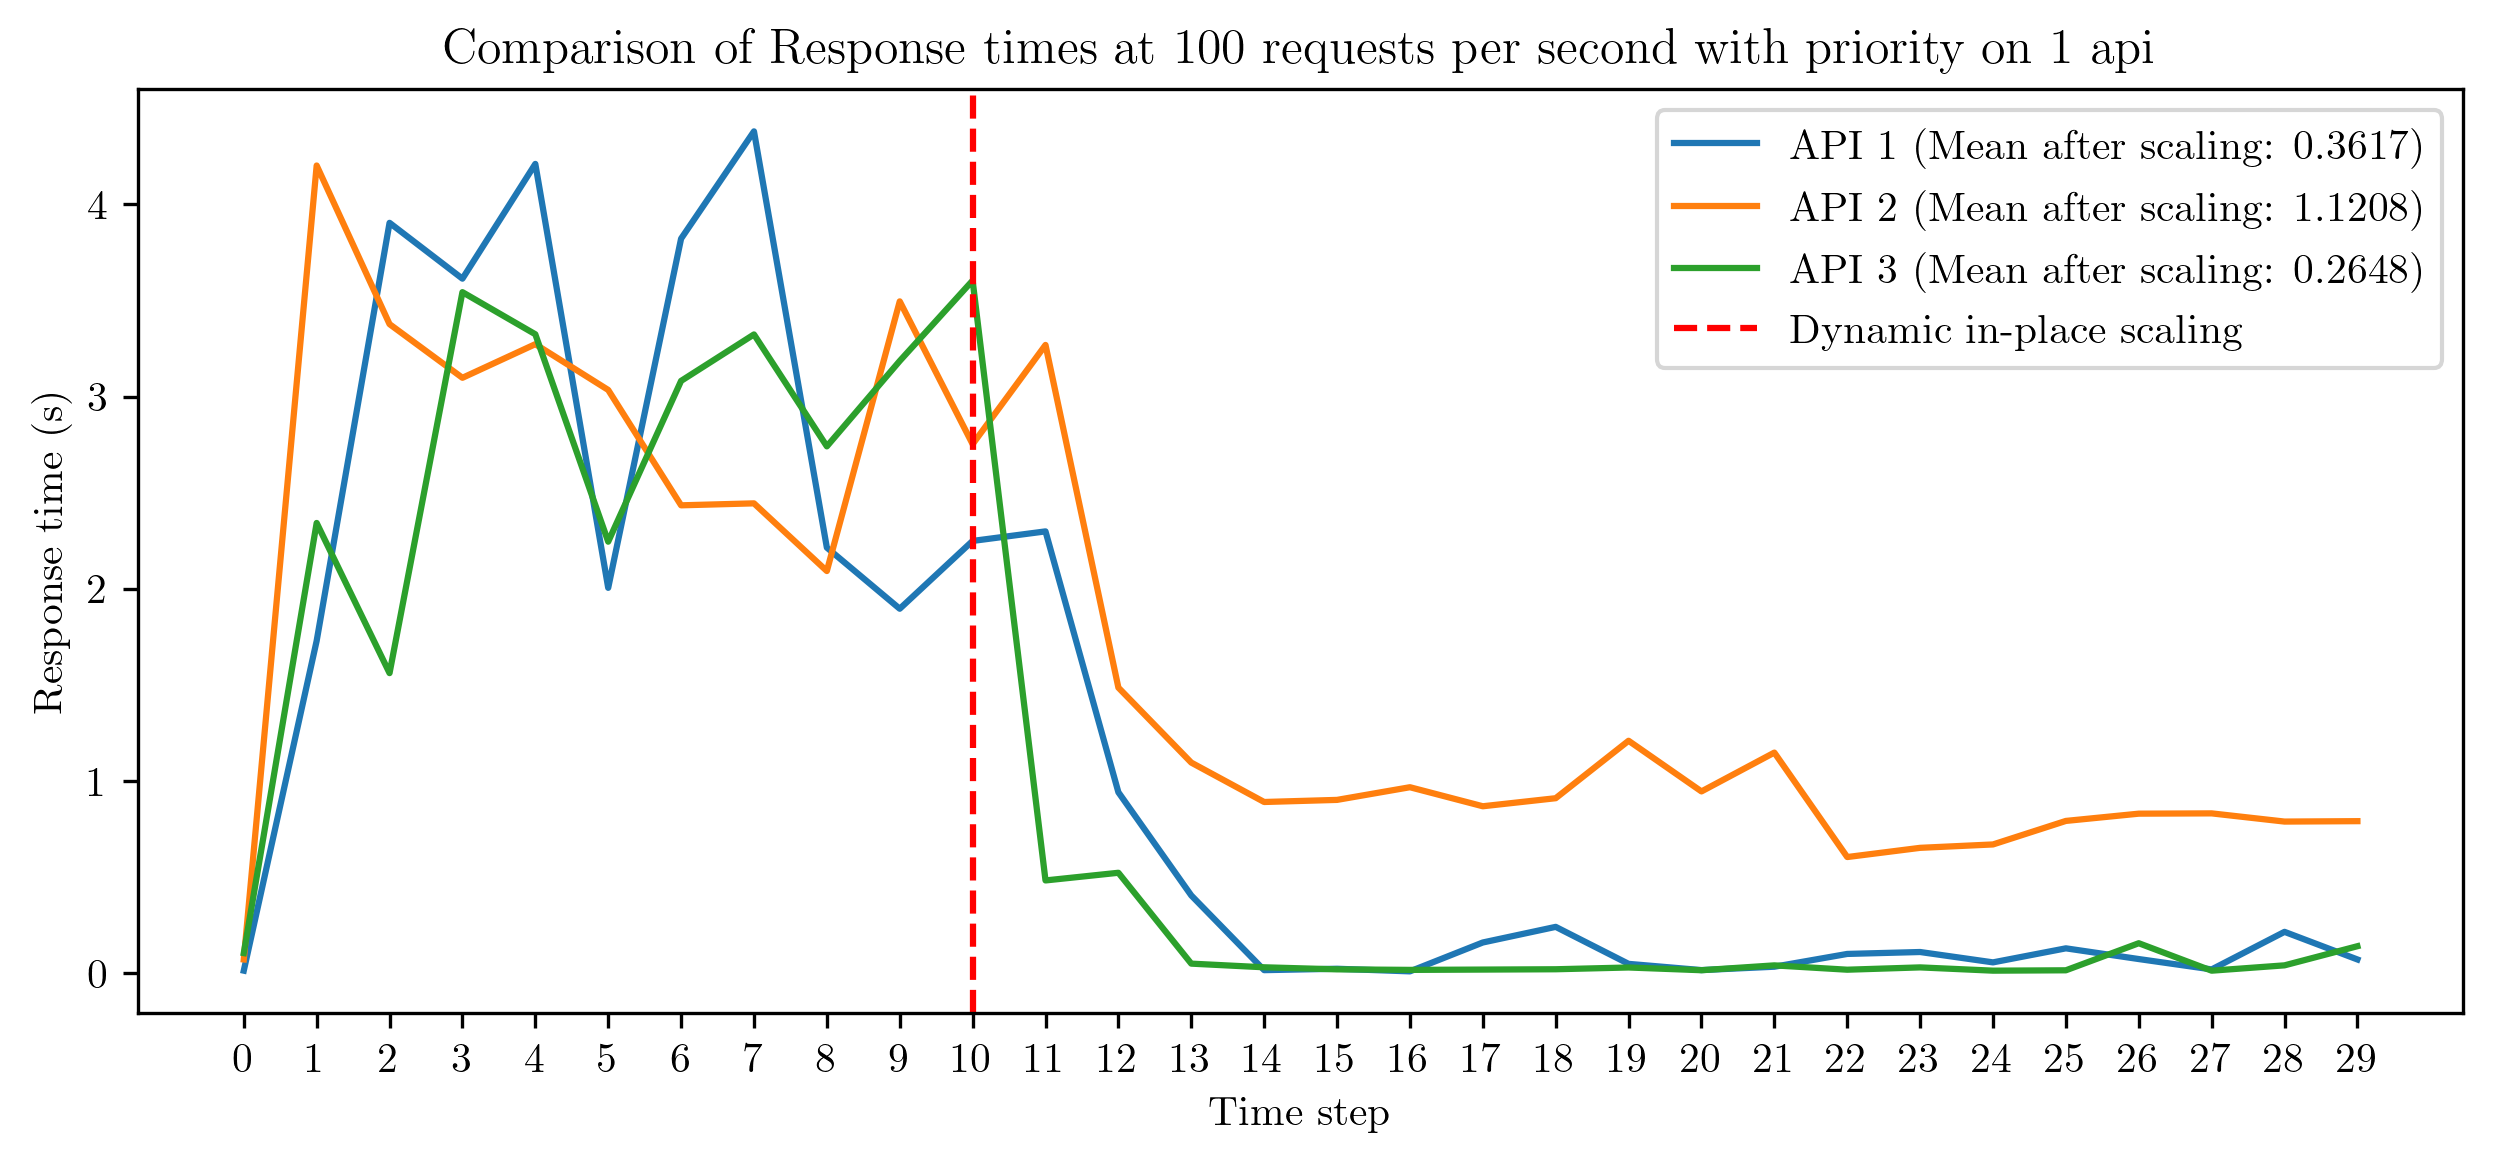

In [6]:
rts = np.array(granullar_ppo_rts).T

plt.figure(figsize=(10, 4), dpi=300)

for i, latency in enumerate(rts):    
    mean_latency = np.mean(latency[len(rts[0]) // divide_at:])
    plt.plot(latency, label=f'API {i + 1} (Mean after scaling: {mean_latency:.4f})')

middle_x = len(rts[0]) // divide_at
plt.axvline(x=middle_x, color='r', linestyle='--', label='Dynamic in-place scaling')

plt.xlabel('Time step')
plt.ylabel('Response time (s)')
plt.title(f'Comparison of Response times at {initial_rps} requests per second with priority on {priority_api} api')
plt.legend()

plt.xticks(np.arange(len(rts[0])))

plt.show()

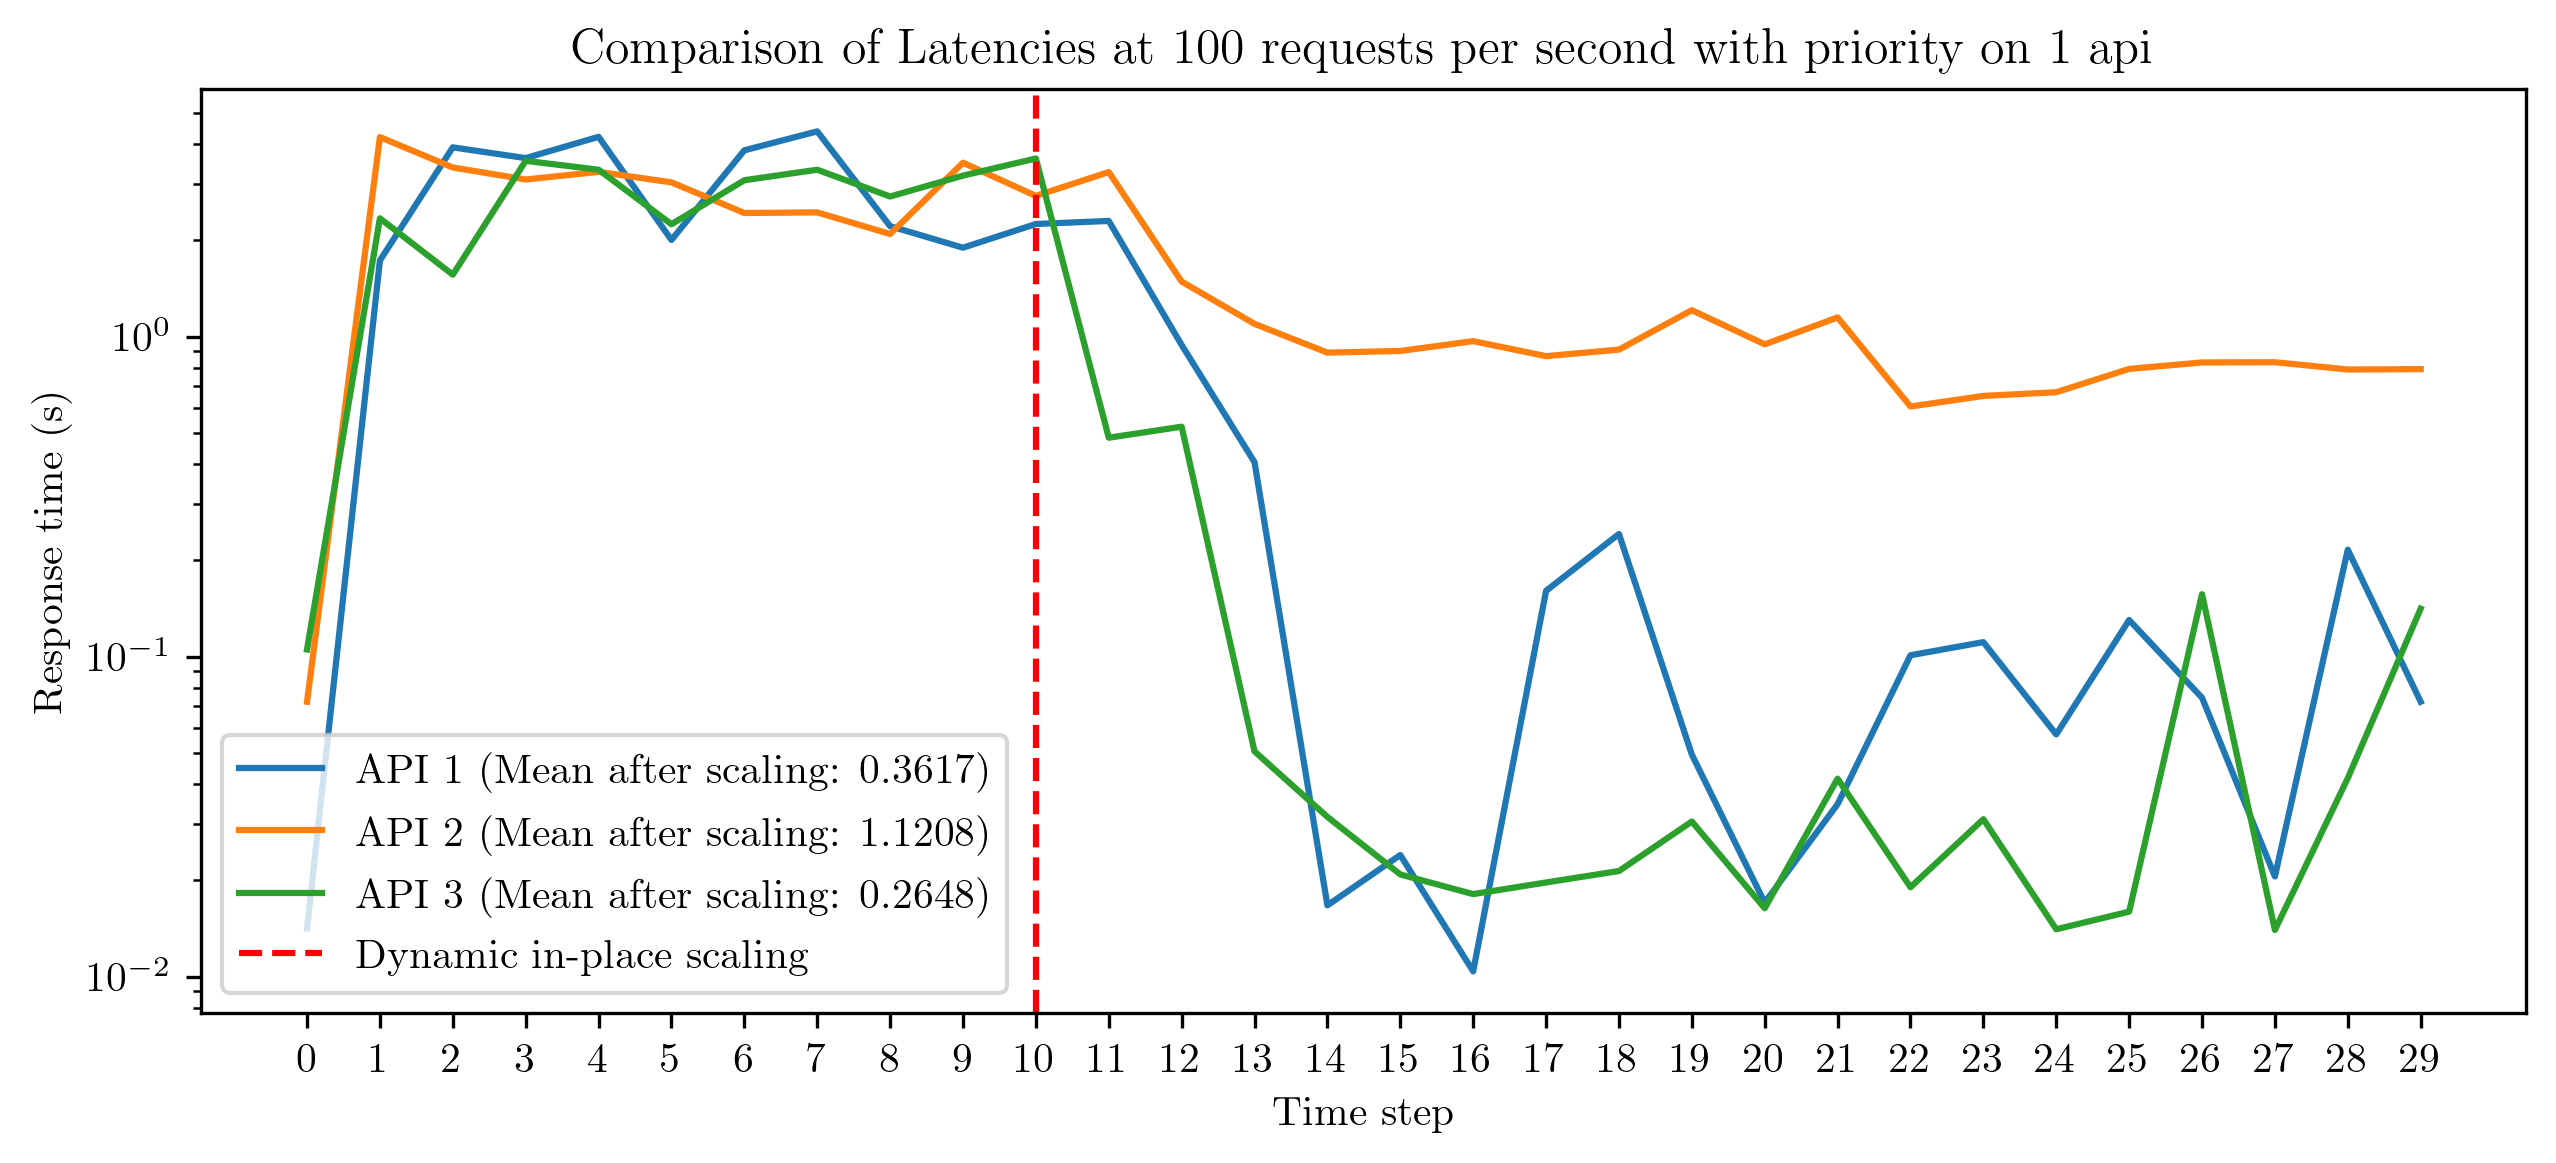

In [7]:
rts = np.array(granullar_ppo_rts).T

plt.figure(figsize=(10, 4), dpi=300)

for i, latency in enumerate(rts):    
    mean_latency = np.mean(latency[len(rts[0]) // divide_at:])
    plt.plot(latency, label=f'API {i + 1} (Mean after scaling: {mean_latency:.4f})')

middle_x = len(rts[0]) // divide_at
plt.axvline(x=middle_x, color='r', linestyle='--', label='Dynamic in-place scaling')

plt.xlabel('Time step')
plt.ylabel('Response time (s)')
plt.yscale('log')
plt.title(f'Comparison of Latencies at {initial_rps} requests per second with priority on {priority_api} api')
plt.legend()

plt.xticks(np.arange(len(rts[0])))

plt.show()

In [8]:
for i, latency in enumerate(rts):
    mean_latency = np.mean(latency[len(rts[0]) // divide_at:])
    print(f"Mean latency for API {i + 1}: {mean_latency}")

Mean latency for API 1: 0.36166402
Mean latency for API 2: 1.120815175
Mean latency for API 3: 0.26475651749999995
